In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Functions

In [7]:
def perform_VAR_p_analysis(data, windows, max_lag, T_pred=25, num_window_samples=5, dt=0.001):
    lags = np.arange(1, max_lag + 1)
    
    grid_search_df = []
    iterator = tqdm(total = len(windows)*len(lags))
    for window in windows:
        stride = window
        min_ind = int(0/stride)
        max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
        possible_inds = np.arange(min_ind, max_ind + 1)
        window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
    #     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
        for p in lags:
    #         for i in range(num_windows):
            for i in window_inds:
                start_ind = i*int(stride/dt)
                start_time = i*stride
                end_ind = i*int(stride/dt) + int(window/dt)
                end_time = i*stride + window
                if end_ind + T_pred <= data.shape[0]:

                    window_data = data[start_ind:end_ind]
                    results = compute_VAR_p(window_data, p)
                    test_data = data[end_ind - p:end_ind + T_pred]

                    train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                    train_mse = ((train_prediction - train_true_vals)**2).mean()
                    test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
    #                 print(test_prediction.shape)
                    test_mse = ((test_prediction - test_true_vals)**2).mean()
                    persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                    # ADD TO DICTIONARY
                    results['train_mse'] = train_mse
                    results['test_mse'] = test_mse
                    results['persistence_baseline'] = persistence_baseline

                    # ADD TIMESTAMPS
                    results['start_ind'] = start_ind
                    results['end_ind'] = end_ind
                    results['start_time'] = start_time
                    results['end_time'] = end_time

                    # ADD PARAMETERS
                    results['window'] = window
                    results['stride'] = stride
                    results['p'] = p
                    results['T_pred'] = T_pred

                    grid_search_df.append(results)
            iterator.update()
    iterator.close()
    grid_search_df = pd.DataFrame(grid_search_df)
    
    test_mse_mat = np.zeros((len(windows), len(lags)))
    for i, window in enumerate(windows):
        for j, p in enumerate(lags):
            test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()
    
    def pick_2d_optimum(mat, thresh=0.95):
        true_min = mat.min()
        i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
        selected_i = np.min(i_vals)
        selected_j = np.min(j_vals[i_vals == selected_i])
        selected_i, selected_j

        return selected_i, selected_j
    thresh = 1
    w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
    
    window = windows[w_ind]
    p = lags[p_ind]
    
    VAR_results = []
    stride = window
    num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
    for i in tqdm(range(num_windows)):
        start_ind = i*int(stride/dt)
        start_time = i*stride
        end_ind = i*int(stride/dt) + int(window/dt)
        end_time = i*stride + window
        if end_ind + T_pred <= data.shape[0]:

            window_data = data[start_ind:end_ind]
            results = compute_VAR_p(window_data, p)
            test_data = data[end_ind - p:end_ind + T_pred]

            train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
            train_mse = ((train_prediction - train_true_vals)**2).mean()
            test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
    #                 print(test_prediction.shape)
            test_mse = ((test_prediction - test_true_vals)**2).mean()
            persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

            # ADD TO DICTIONARY
            results['train_mse'] = train_mse
            results['test_mse'] = test_mse
            results['persistence_baseline'] = persistence_baseline

            # ADD TIMESTAMPS
            results['start_ind'] = start_ind
            results['end_ind'] = end_ind
            results['start_time'] = start_time
            results['end_time'] = end_time

            # ADD PARAMETERS
            results['window'] = window
            results['stride'] = stride
            results['p'] = p
            results['T_pred'] = T_pred

            VAR_results.append(results)
    VAR_results = pd.DataFrame(VAR_results)
    
    return VAR_results, grid_search_df, test_mse_mat, window, p

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(highcut, fs, order=5):
    return butter(order, highcut, fs=fs, btype='low')

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Get Signals

In [91]:
subsample_step = 4
order = 25
# lowpass_freq = (1/(2 * dt * subsample_step))
lowpass_freq = (1/(2 * dt * subsample_step))/2

In [92]:
lowpass_freq

62.5

In [93]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

big_window_start = 30*60 # s
big_window_length = 100 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
signal_in = lfp[big_window_start_ind:big_window_end_ind, area_indices]
# for i in range(signal_in.shape[1]):
#     signal_in[:, i] = butter_lowpass_filter(signal_in[:, i], 100, 1/dt)
# signal_in_subsampled = signal_in[np.arange(0, signal_in.shape[0], 2)]

signal_in_filtered = np.zeros(signal_in.shape)
for i in range(signal_in.shape[1]):
    signal_in_filtered[:, i] = butter_lowpass_filter(signal_in[:, i], lowpass_freq, 1/dt, order=order)
signal_in_subsampled = signal_in_filtered[np.arange(0, signal_in.shape[0], subsample_step)]  

In [94]:
i = 0

In [95]:
nperseg = 1000
f, t, Zxx = scipy.signal.stft(signal_in[:, i], fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
f_filtered, t_filtered, Zxx_filtered = scipy.signal.stft(signal_in_filtered[:, i], fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
f_subsampled, t_subsampled, Zxx_subsampled = scipy.signal.stft(signal_in_subsampled[:, i], fs=1/(dt*subsample_step), window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)

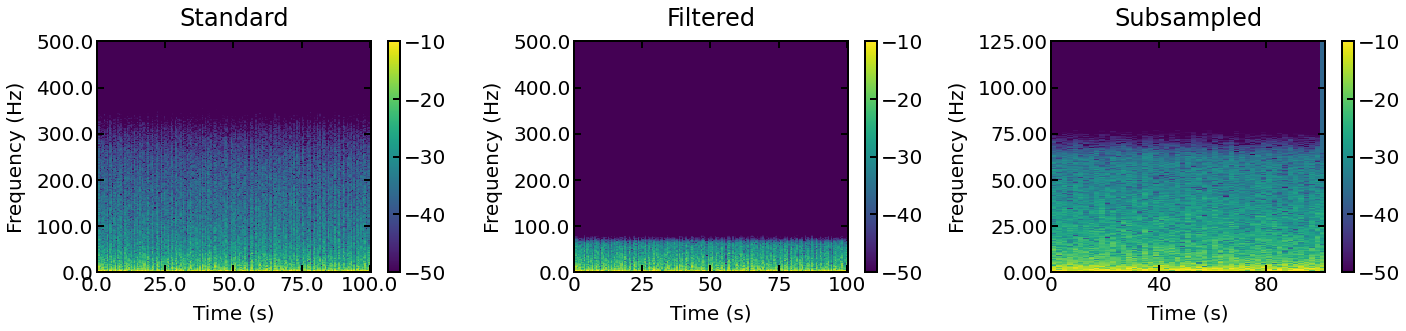

In [96]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(10*np.log10(np.abs(Zxx)))
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks([tick for tick in xticks if tick < len(t)], [int(tick)*(nperseg/2)*dt for tick in xticks if tick < len(t)])
yticks = ax.get_yticks()
plt.yticks([tick for tick in yticks if tick < len(f)], [f[int(tick)] for tick in yticks if tick < len(f)])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Standard')
# print(plt.get_xticks())
# plt.ylim([0, ])
plt.clim([-50, -10])
plt.colorbar()
plt.subplot(1, 3, 2)
plt.pcolormesh(10*np.log10(np.abs(Zxx_filtered)))
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks([tick for tick in xticks if tick < len(t_filtered)], [int(tick*nperseg*dt/2) for tick in xticks if tick < len(t_filtered)])
yticks = ax.get_yticks()
plt.yticks([tick for tick in yticks if tick < len(f_filtered)], [f_filtered[int(tick)] for tick in yticks if tick < len(f_filtered)])
# print(plt.get_xticks())
plt.clim([-50, -10])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Filtered')
# plt.ylim([0, 40])
plt.colorbar()
plt.subplot(1, 3, 3)
plt.pcolormesh(10*np.log10(np.abs(Zxx_subsampled)))
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks([tick for tick in xticks if tick < len(t_subsampled)], [int(tick*(nperseg/2)*dt*subsample_step) for tick in xticks if tick < len(t_subsampled)])
yticks = ax.get_yticks()
plt.yticks([tick for tick in yticks if tick < len(f_subsampled)], [f"{f_subsampled[int(tick)]:.2f}" for tick in yticks if tick < len(f_subsampled)])
# print(plt.get_xticks())
plt.clim([-50, -10])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Subsampled')
# plt.ylim([0, 40])
plt.colorbar()
plt.tight_layout()
plt.show()

In [58]:
# plt.plot(np.abs(Zxx)[f == 1][0], label='original f=1')
# plt.plot(np.arange(0, Zxx.shape[1], 2), np.abs(Zxx_subsampled)[f == 2][0], label='subsampled f=2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

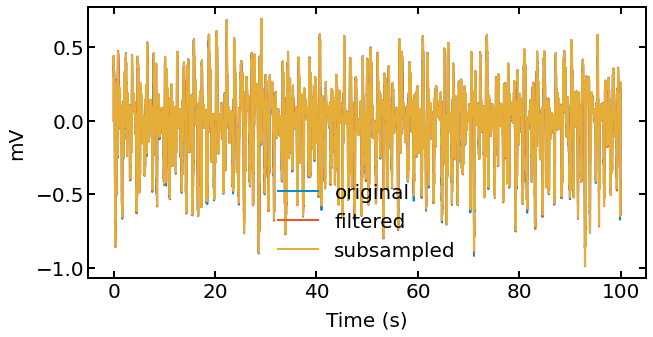

In [59]:
plt.plot(np.arange(signal_in.shape[0])*dt, signal_in[:, i], label='original')
plt.plot(np.arange(signal_in_filtered.shape[0])*dt, signal_in_filtered[:, i], label='filtered')
plt.plot(np.arange(0, signal_in.shape[0], subsample_step)*dt, signal_in_subsampled[:, i], label='subsampled')
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.legend()
plt.show()

In [60]:
signals = {
    'standard': signal_in,
    'filtered': signal_in_filtered,
    'subsampled': signal_in_subsampled,
}

signal_analysis = {}

# VAR Grid Search

In [61]:
d = 16
indices = np.random.choice(np.arange(signal_in.shape[1]), size=(d, ), replace=False)

In [62]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
# num_window_samples = 5
num_window_samples = 2

In [63]:
for key, signal in signals.items():
    if key not in signal_analysis.keys():
        print(f"now computing: {key}")
        data = signal[:, indices]
        if key == 'subsampled':
            signal_dt = dt*subsample_step
        else:
            signal_dt = dt
        VAR_results, grid_search_df, test_mse_mat, window, p = perform_VAR_p_analysis(data, windows, max_lag, T_pred=T_pred, num_window_samples=num_window_samples, dt=signal_dt)
        signal_analysis[key] = dict(
            VAR_results=VAR_results,
            grid_search_df=grid_search_df,
            test_mse_mat=test_mse_mat,
            window=window,
            p=p
        )

now computing: standard


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

now computing: filtered


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

now computing: subsampled


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

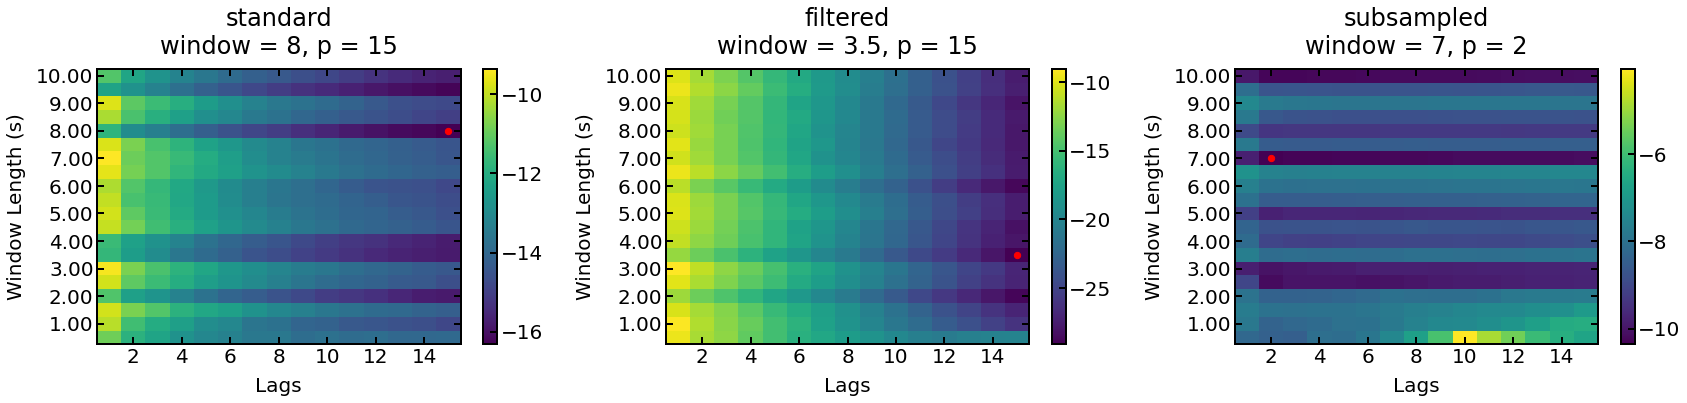

In [64]:
rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 6))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    log_test_mse_mat = np.log(signal_info['test_mse_mat'])
    im = ax.pcolormesh(log_test_mse_mat)
    ax.set_xticks(np.arange(1, max_lag, 2) + 0.5)
    ax.set_xticklabels([lags[i] for i in np.arange(1, max_lag, 2)])
    ax.set_yticks(np.arange(1, len(windows), 2) + 0.5)
    ax.set_yticklabels([f"{windows[i]:.2f}" for i in np.arange(1, len(windows), 2)])
    ax.set_xlabel('Lags')
    ax.set_ylabel('Window Length (s)')
    ax.set_title(f"{key}\nwindow = {signal_info['window']}, p = {signal_info['p']}")
    fig.colorbar(im, ax=ax)
    p_ind = np.where(lags == signal_info['p'])[0][0]
    w_ind = np.where(np.array(windows) == signal_info['window'])[0][0]
    ax.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()

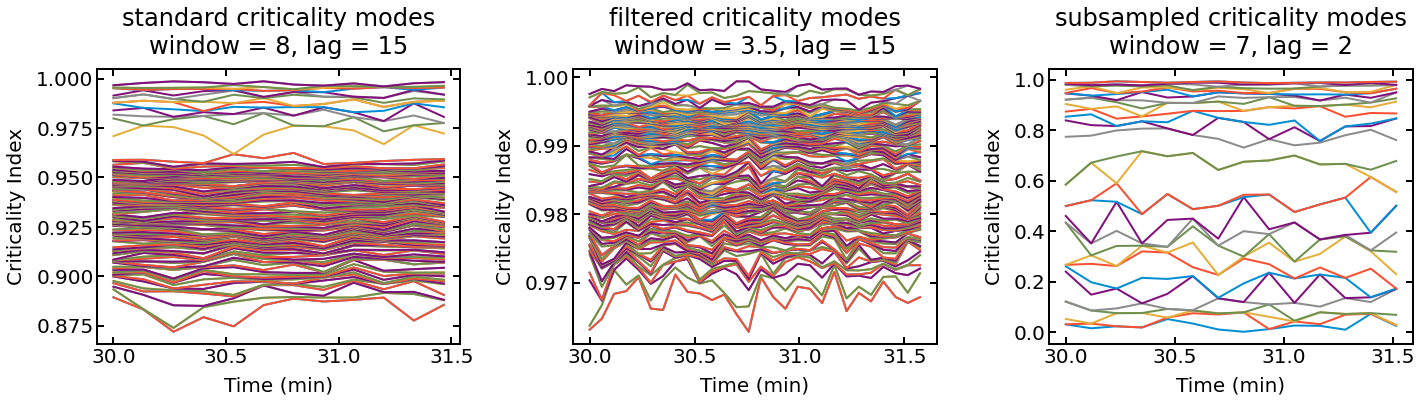

In [65]:
rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    VAR_results = signal_info['VAR_results']
    mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
    for i, row in VAR_results.iterrows():
        mode_criticalities[i] = np.sort(row.criticality_inds)
    for i in range(len(VAR_results.criticality_inds.iloc[0])):
        ax.plot((VAR_results.start_time + big_window_start)/60, mode_criticalities[:, i])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Criticality Index')
    ax.set_title(f"{key} criticality modes\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

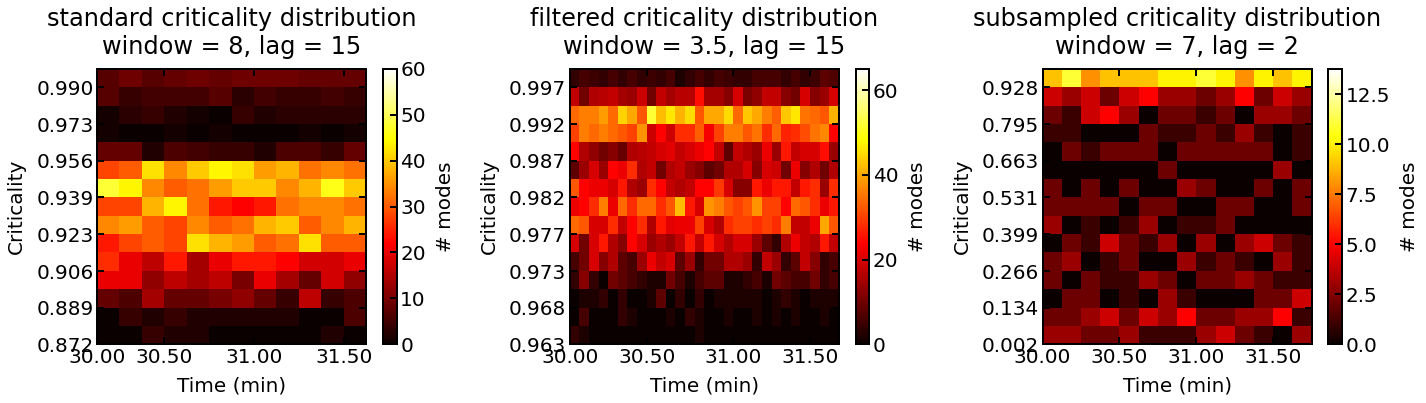

In [66]:
rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    VAR_results = signal_info['VAR_results']
    
    stride = VAR_results.stride.iloc[0]
    bin_nums = 15
    bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
    bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
    bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
    for t in range(VAR_results.criticality_inds.shape[0]):
        criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
    start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
    T_max = VAR_results.criticality_inds.shape[0]*stride
    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
    ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 30)])
    ax.set_xticklabels([f"{(int(i) + big_window_start)/60:.2f}" for i in np.arange(0, T_max, 30)])
    ax.set_yticks(np.arange(0, bin_nums + 1, 2))
    ax.set_yticklabels([f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(label='# modes')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Criticality")
    ax.set_title(f"{key} criticality distribution\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

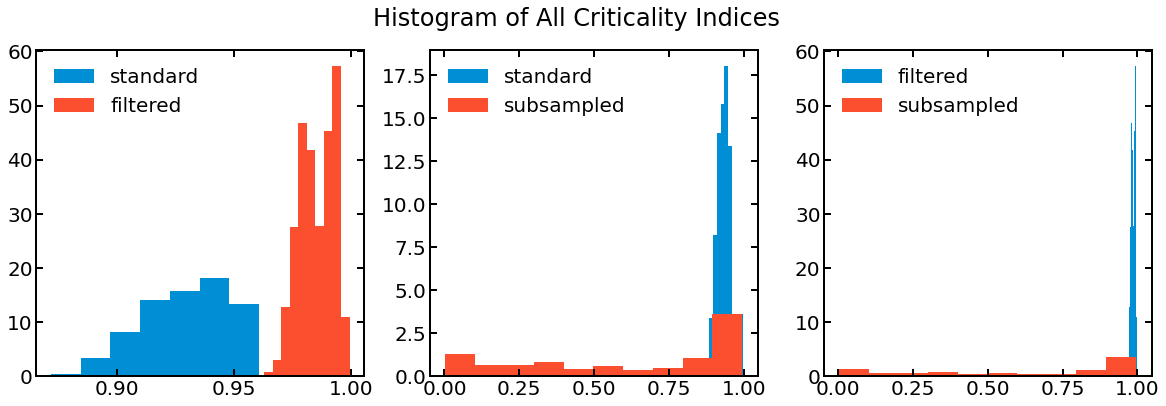

In [67]:
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        ax.hist(all_standard_inds, density=True, label='standard')
        ax.hist(all_filtered_inds, density=True, label='filtered')
    elif i == 1:
        ax.hist(all_standard_inds, density=True, label='standard')
        ax.hist(all_subsampled_inds, density=True, label='subsampled')
    elif i == 2:
        ax.hist(all_filtered_inds, density=True, label='filtered')
        ax.hist(all_subsampled_inds, density=True, label='subsampled')
    ax.legend()
plt.suptitle('Histogram of All Criticality Indices')
plt.show()

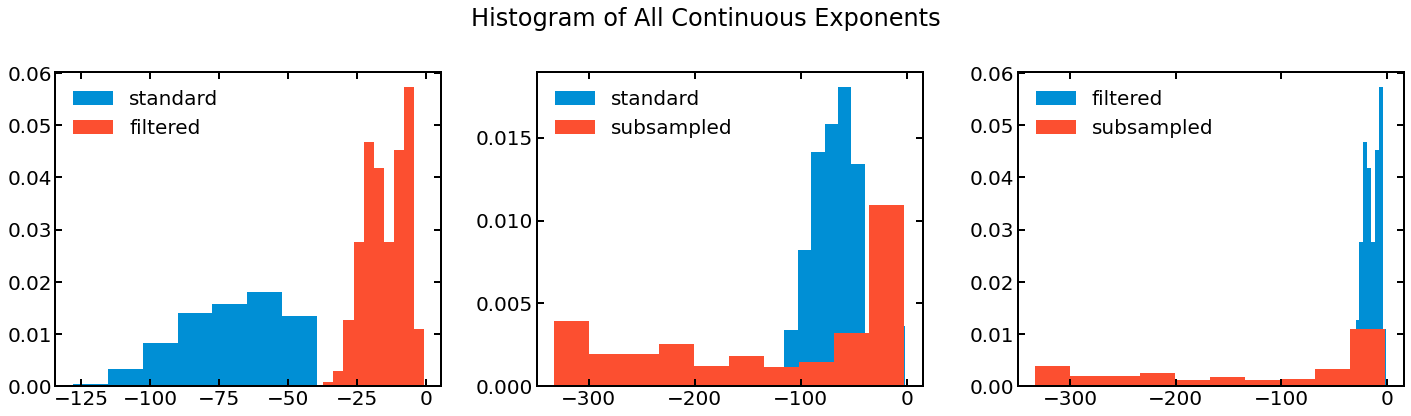

In [68]:
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        ax.hist((all_standard_inds - 1)/dt, density=True, label='standard')
        ax.hist((all_filtered_inds - 1)/dt, density=True, label='filtered')
    elif i == 1:
        ax.hist((all_standard_inds - 1)/dt, density=True, label='standard')
        ax.hist((all_subsampled_inds - 1)/(dt*subsample_step), density=True, label='subsampled')
    elif i == 2:
        ax.hist((all_filtered_inds - 1)/dt, density=True, label='filtered')
        ax.hist((all_subsampled_inds - 1)/(dt*subsample_step), density=True, label='subsampled')
    ax.legend()
plt.suptitle('Histogram of All Continuous Exponents')
plt.tight_layout()
plt.show()

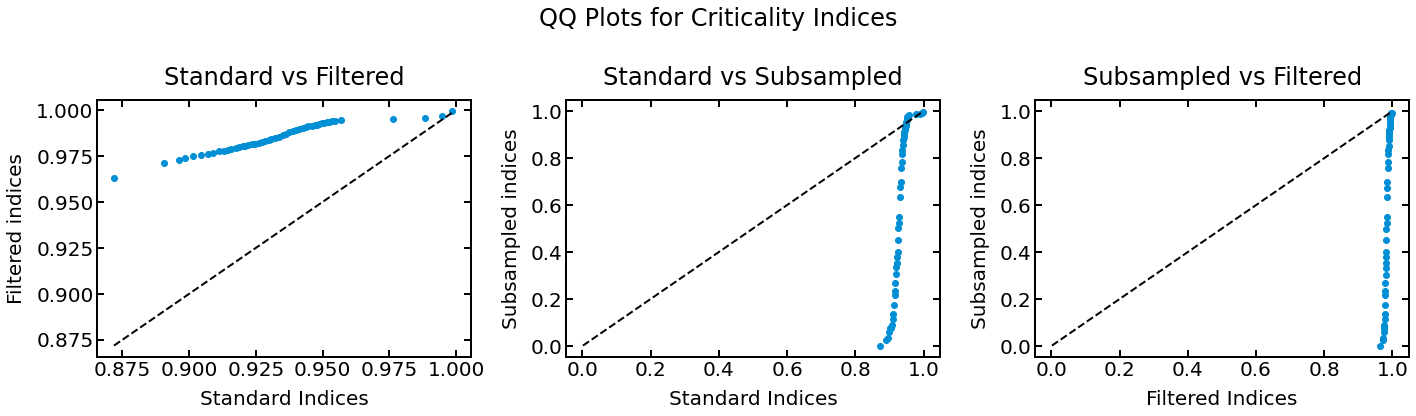

In [69]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0, 1, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        qqplot(all_standard_inds, all_filtered_inds, ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Indices')
        ax.set_ylabel(f"Filtered indices")
        ax.set_title('Standard vs Filtered')
    elif i == 1:
        qqplot(all_standard_inds, all_subsampled_inds, ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Indices')
        ax.set_ylabel(f"Subsampled indices")
        ax.set_title('Standard vs Subsampled')
    elif i == 2:
        qqplot(all_filtered_inds, all_subsampled_inds, ax=ax, num_quantiles=50)
        ax.set_xlabel('Filtered Indices')
        ax.set_ylabel(f"Subsampled indices")
        ax.set_title('Subsampled vs Filtered')
plt.suptitle('QQ Plots for Criticality Indices')
plt.tight_layout()
plt.show()

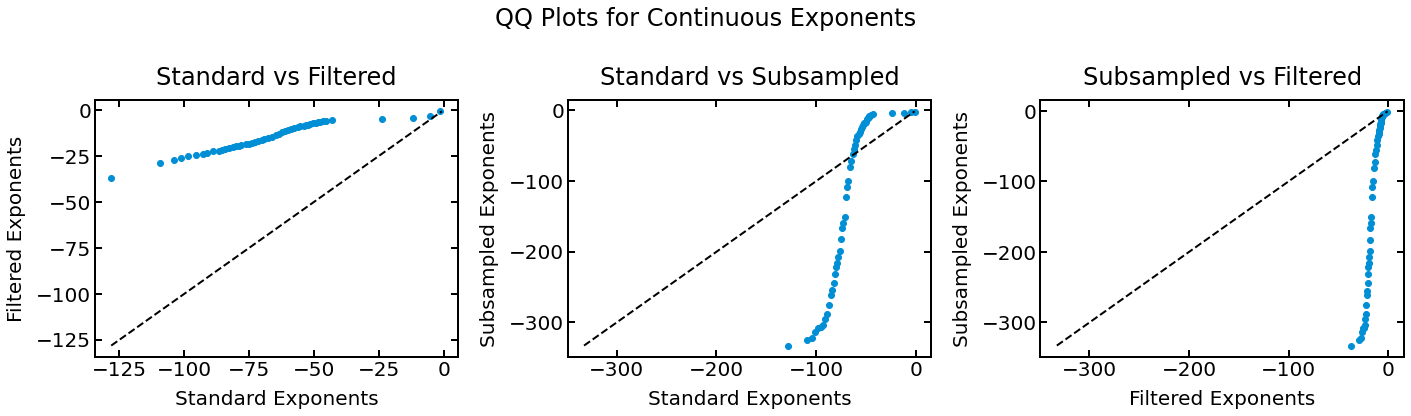

In [70]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0, 1, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        qqplot((all_standard_inds - 1)/dt, (all_filtered_inds - 1)/dt, ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Filtered Exponents")
        ax.set_title('Standard vs Filtered')
    elif i == 1:
        qqplot((all_standard_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Standard vs Subsampled')
    elif i == 2:
        qqplot((all_filtered_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Filtered Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Subsampled vs Filtered')
plt.suptitle('QQ Plots for Continuous Exponents')
plt.tight_layout()
plt.show()

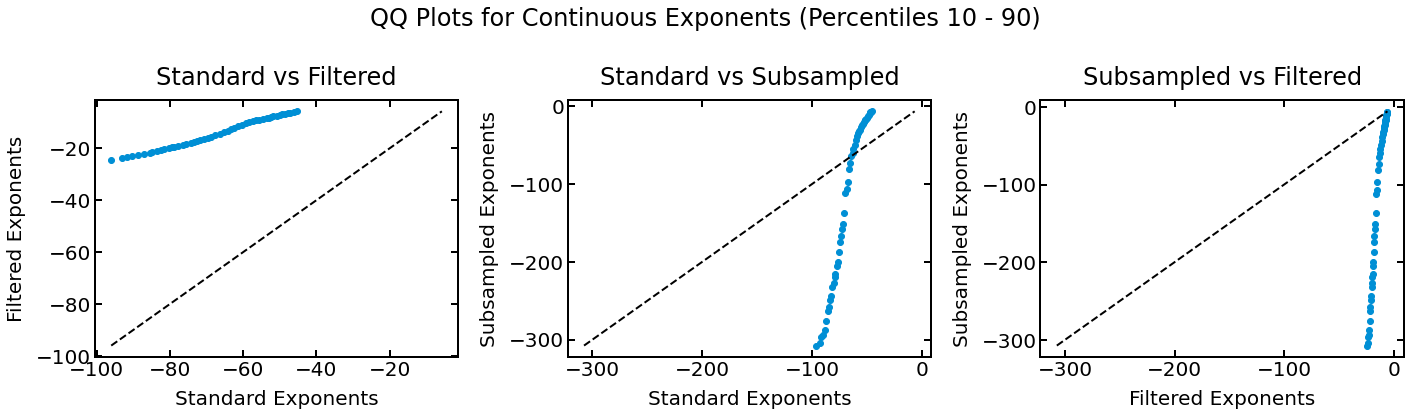

In [71]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0.1, 0.9, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

# max_val = np.max([((all_standard_inds - 1)/dt).max(), ((all_filtered_inds - 1)/dt).max(), ((all_subsampled_inds - 1)/(dt*subsample_step)).max()])
# min_val = np.min([((all_standard_inds - 1)/dt).min(), ((all_filtered_inds - 1)/dt).min(), ((all_subsampled_inds - 1)/(dt*subsample_step)).min()])

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        qqplot((all_standard_inds - 1)/dt, (all_filtered_inds - 1)/dt, ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Filtered Exponents")
        ax.set_title('Standard vs Filtered')
    elif i == 1:
        qqplot((all_standard_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Standard vs Subsampled')
    elif i == 2:
        qqplot((all_filtered_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Filtered Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Subsampled vs Filtered')
#     ax.set_xlim([min_val, max_val])
#     ax.set_ylim([min_val, max_val])
#     ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), c='k', linestyle='--')
plt.suptitle('QQ Plots for Continuous Exponents (Percentiles 10 - 90)')
plt.tight_layout()
plt.show()

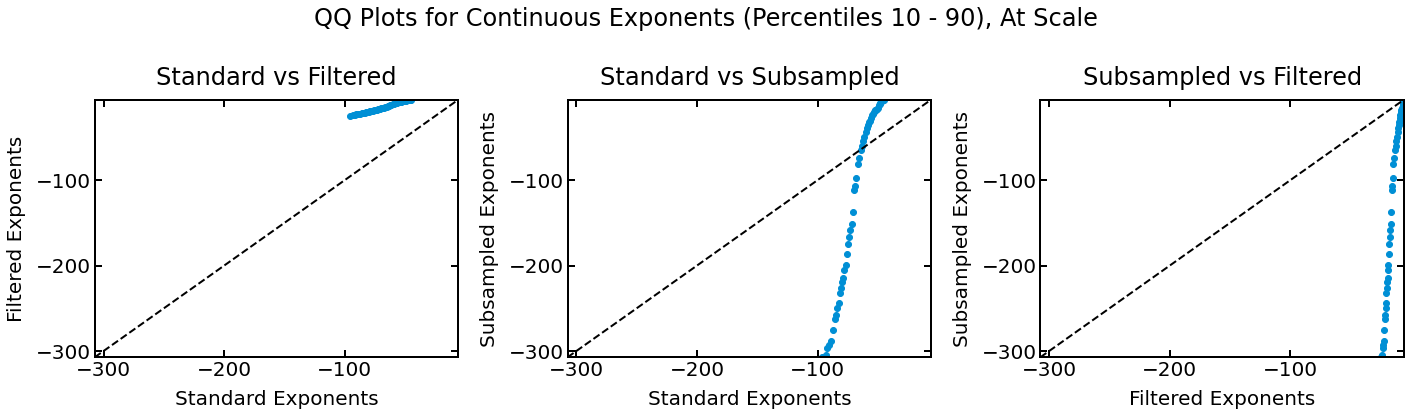

In [72]:
quantile_low = 0.1
quantile_high = 0.9
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(quantile_low, quantile_high, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
#     min_val = np.min([x_quantiles.min(), y_quantiles.min()])
#     max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
#     ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

max_val = np.max([np.quantile(((all_standard_inds - 1)/dt), quantile_high), np.quantile(((all_filtered_inds - 1)/dt), quantile_high), np.quantile(((all_subsampled_inds - 1)/(dt*subsample_step)), quantile_high)])
min_val = np.min([np.quantile(((all_standard_inds - 1)/dt), quantile_low), np.quantile(((all_filtered_inds - 1)/dt), quantile_low), np.quantile(((all_subsampled_inds - 1)/(dt*subsample_step)), quantile_low)])

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        qqplot((all_standard_inds - 1)/dt, (all_filtered_inds - 1)/dt, ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Filtered Exponents")
        ax.set_title('Standard vs Filtered')
    elif i == 1:
        qqplot((all_standard_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Standard vs Subsampled')
    elif i == 2:
        qqplot((all_filtered_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Filtered Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Subsampled vs Filtered')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), c='k', linestyle='--')
plt.suptitle(f'QQ Plots for Continuous Exponents (Percentiles {int(quantile_low*100)} - {int(quantile_high*100)}), At Scale')
plt.tight_layout()
plt.show()

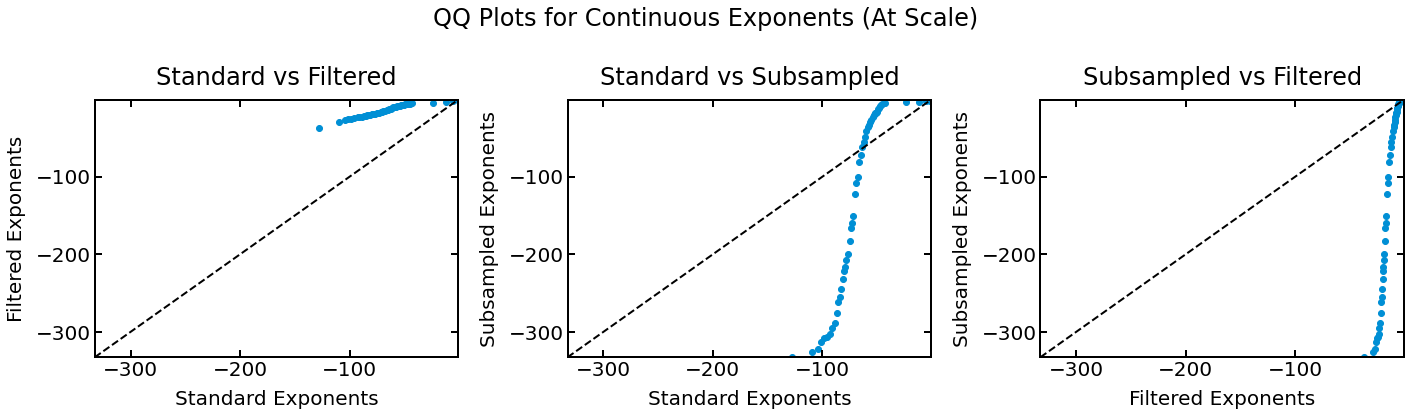

In [73]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0, 1, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
#     ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)
all_filtered_inds = np.hstack(signal_analysis['filtered']['VAR_results'].criticality_inds)
all_subsampled_inds = np.hstack(signal_analysis['subsampled']['VAR_results'].criticality_inds)

max_val = np.max([((all_standard_inds - 1)/dt).max(), ((all_filtered_inds - 1)/dt).max(), ((all_subsampled_inds - 1)/(dt*subsample_step)).max()])
min_val = np.min([((all_standard_inds - 1)/dt).min(), ((all_filtered_inds - 1)/dt).min(), ((all_subsampled_inds - 1)/(dt*subsample_step)).min()])

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 6))

for i in range(3):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if i == 0:
        qqplot((all_standard_inds - 1)/dt, (all_filtered_inds - 1)/dt, ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Filtered Exponents")
        ax.set_title('Standard vs Filtered')
    elif i == 1:
        qqplot((all_standard_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Standard Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Standard vs Subsampled')
    elif i == 2:
        qqplot((all_filtered_inds - 1)/dt, (all_subsampled_inds - 1)/(dt*subsample_step), ax=ax, num_quantiles=50)
        ax.set_xlabel('Filtered Exponents')
        ax.set_ylabel(f"Subsampled Exponents")
        ax.set_title('Subsampled vs Filtered')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), c='k', linestyle='--')
plt.suptitle('QQ Plots for Continuous Exponents (At Scale)')
plt.tight_layout()
plt.show()